# 1. Import Libraries

In [1]:
import os
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sn
from collections import Counter
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras import regularizers

import keras.backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

from IPython.display import Image, HTML
from tensorflow.keras.utils import plot_model

print('done')

done


# 2. Parameter

In [2]:
# declare path
train_path = 'fer2013/train/'
test_path = 'fer2013/test/'

# Image size

img_size = (48,48)
img_shape = img_size + (3,)

classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']
print('done')

done


# 3. Prepare data

 Data augmentation

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

test_datagen  = ImageDataGenerator(rescale = 1./255)
print('done')

done


Load datasat

In [4]:
train_dataset  = train_datagen.flow_from_directory(directory = train_path,
                                                   target_size = img_size,
                                                   class_mode = 'categorical',
                                                   batch_size = 64)

test_dataset = test_datagen.flow_from_directory(directory = test_path,
                                                  target_size = img_size,
                                                  class_mode = 'categorical',
                                                  shuffle =True,
                                                  batch_size = 64)
print('done')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
done


# 4. Explore data

In [5]:
# Data labels

class_labels = test_dataset.class_indices
class_labels

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

See the shape of any data

In [6]:
train_sample=next(train_dataset)
print(train_sample[0].shape)

(64, 48, 48, 3)


Total train/test sample

In [7]:
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + '/'+ expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_path, 'train')
test_count = count_exp(test_path, 'test')



lot distribution of train/test dataste per class

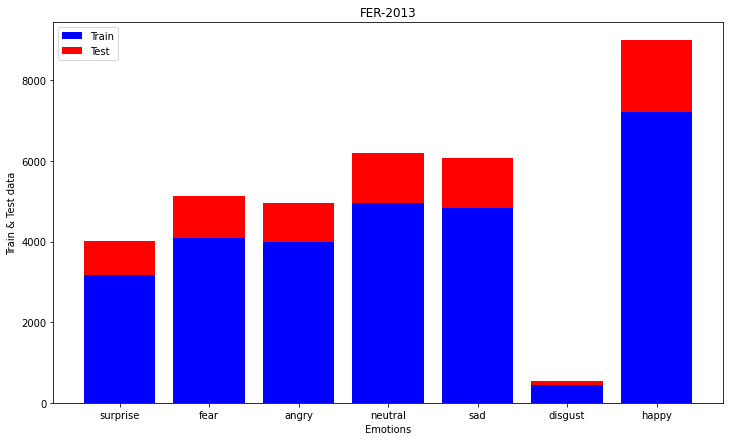

In [8]:
x = list(test_count.columns)
y1 =train_count.iloc[0].to_list()
y2 = test_count.iloc[0].to_list()
plt.figure(figsize=(12,7))

plt.bar(x, y1, color='blue')
plt.bar(x, y2, bottom=y1, color='red')
plt.xlabel("Emotions")
plt.ylabel("Train & Test data")
plt.legend(["Train", "Test"], loc='upper left')
plt.title("FER-2013")
plt.savefig('distribution.png')
plt.show()

Plot image of each class

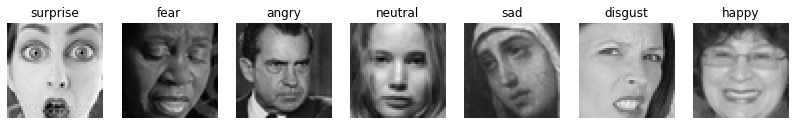

In [9]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_path):
    img = load_img((train_path + expression +'/'+ os.listdir(train_path + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

# 5. Model

# Mobinet

In [10]:
base_model = tf.keras.applications.MobileNet(input_shape=img_shape, include_top=False, weights='imagenet')
base_model.summary()

2022-08-26 09:01:59.929426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 09:02:00.075519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 09:02:00.076330: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-26 09:02:00.078010: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

17235968/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 24, 24, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 24, 24, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 24, 24, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 24, 24, 32)        128       
_________________________________________________

# Freezing Layers


In [11]:
for layer in base_model.layers[:-9]:
    layer.trainable=False

print('done')

done


In [12]:
print("Model trainable",len(base_model.layers))

Model trainable 86


In [13]:
print("Model trainable",len(base_model.trainable_variables))

Model trainable 9


Model trainable

In [14]:
print("Model trainable",len(base_model.trainable_variables))

Model trainable 9


# Build transfer learning Model

In [15]:
model=Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(7, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1, 1, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3

# Compile model

In [16]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

Metrics = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=Metrics)
print('done')

done


# Run Model

In [17]:
counter = Counter(train_dataset.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}  

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 10,verbose = 1,factor = 0.50, min_lr = 1e-10)
checkpoint = ModelCheckpoint('model.h5')
early_stopping = EarlyStopping(verbose=1, patience=20)

history=model.fit(train_dataset,
                  validation_data=test_dataset,
                  epochs = 125,
                  verbose =1,
                  callbacks = [lrd,checkpoint,early_stopping], 
                  class_weight = class_weights)

2022-08-26 09:02:05.152814: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/125


2022-08-26 09:02:09.182889: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


449/449 [==============================] - 207s 441ms/step - loss: 4.8371 - accuracy: 0.8259 - precision: 0.2413 - recall: 0.1019 - auc: 0.5800 - f1_score: 0.1432 - val_loss: 2.4014 - val_accuracy: 0.8550 - val_precision: 0.4772 - val_recall: 0.1587 - val_auc: 0.7060 - val_f1_score: 0.2354
Epoch 2/125
449/449 [==============================] - 57s 127ms/step - loss: 4.2766 - accuracy: 0.8396 - precision: 0.3329 - recall: 0.1225 - auc: 0.6344 - f1_score: 0.1785 - val_loss: 2.3244 - val_accuracy: 0.8603 - val_precision: 0.5303 - val_recall: 0.1941 - val_auc: 0.7318 - val_f1_score: 0.2818
Epoch 3/125
449/449 [==============================] - 56s 125ms/step - loss: 4.0465 - accuracy: 0.8449 - precision: 0.3666 - recall: 0.1179 - auc: 0.6557 - f1_score: 0.1775 - val_loss: 2.2724 - val_accuracy: 0.8612 - val_precision: 0.5434 - val_recall: 0.1796 - val_auc: 0.7394 - val_f1_score: 0.2669
Epoch 4/125
449/449 [==============================] - 57s 126ms/step - loss: 3.8770 - accuracy: 0.8485 -

# 6. Evaluate Model

## 6.1 Check some Score 

Scores of train & test set

In [18]:
train_evalation = model.evaluate(train_dataset)
test_evaluation = model.evaluate(test_dataset)

113/113 [==============================] - 7s 63ms/step - loss: 1.4683 - accuracy: 0.8810 - precision: 0.6179 - recall: 0.4376 - auc: 0.8604 - f1_score: 0.5110


## 6.2 Visualize results

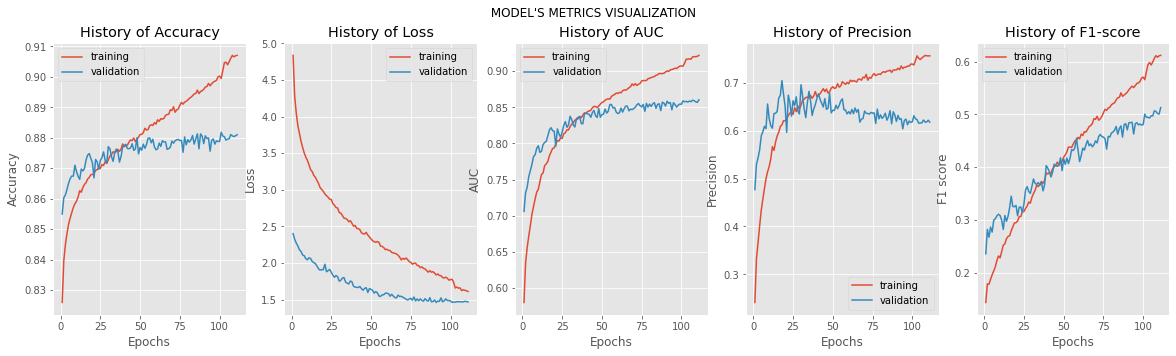

In [19]:
hs=history.history

acc = hs['accuracy']
val_acc = hs['val_accuracy']
loss =  hs['loss']
val_loss = hs['val_loss']
auc =  hs['auc']
val_auc = hs['val_auc']
precision =hs['precision']
val_precision =hs['val_precision']
f1 = hs['f1_score']
val_f1 = hs['val_f1_score']              

plt.style.use('ggplot')

fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

ax1.plot(range(1, len(acc) + 1), acc)
ax1.plot(range(1, len(val_acc) + 1), val_acc)
ax1.set_title('History of Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['training', 'validation'])


ax2.plot(range(1, len(loss) + 1), loss)
ax2.plot(range(1, len(val_loss) + 1), val_loss)
ax2.set_title('History of Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(['training', 'validation'])

ax3.plot(range(1, len(auc) + 1), auc)
ax3.plot(range(1, len(val_auc) + 1), val_auc)
ax3.set_title('History of AUC')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('AUC')
ax3.legend(['training', 'validation'])

ax4.plot(range(1, len(precision) + 1), precision)
ax4.plot(range(1, len(val_precision) + 1), val_precision)
ax4.set_title('History of Precision')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Precision')
ax4.legend(['training', 'validation'])

ax5.plot(range(1, len(f1) + 1), f1)
ax5.plot(range(1, len(val_f1) + 1), val_f1)
ax5.set_title('History of F1-score')
ax5.set_xlabel('Epochs')
ax5.set_ylabel('F1 score')
ax5.legend(['training', 'validation'])

plt.show()

## 6.3 Confusion Matrix

In [20]:
y_true = test_dataset.classes
y_pred =  model.predict(test_dataset)
y_pred= tf.argmax(y_pred, axis = 1).numpy()

cm = confusion_matrix(y_true = y_true, y_pred = y_pred)

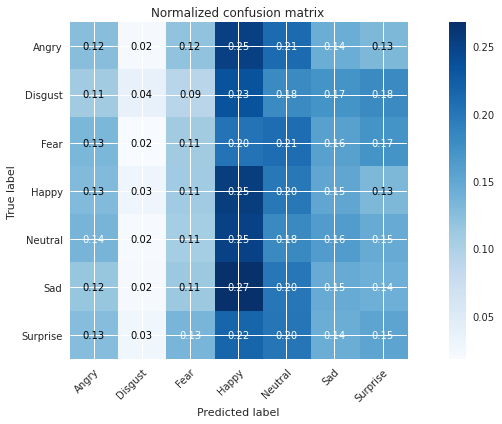

In [21]:
plt.style.use('seaborn')

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(12,6))

im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title = 'Normalized confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


fmt = '.2f' 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()


# 7. Save Model

In [22]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


(48, 48, 1)


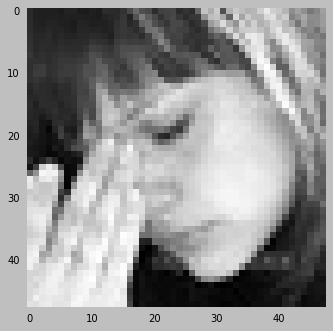

10702106

In [23]:
plt.style.use('grayscale')
plt.grid(visible=None)
img_path='fer2013/test/sad/PrivateTest_10702106.jpg'
test_image=image.load_img(img_path,target_size= img_size,color_mode='grayscale')
test_image=image.img_to_array(test_image)
print(test_image.shape)
plt.imshow(test_image)
plt.show()

10702106


# 8. Test/Predict

In [24]:
img=image.load_img(img_path,target_size=img_size)
img = np.expand_dims(img, axis=0)
print(img.shape)

(1, 48, 48, 3)


In [25]:
result=model.predict(img)
print(result[0])
y_pred=np.argmax(result[0])
print('The person facial emotion is:',classes[y_pred])

[2.0795016e-02 1.9091691e-04 6.4420514e-02 1.5454856e-03 7.6981536e-03
 8.5047293e-01 5.4877050e-02]
The person facial emotion is: Sad
